## Variational Autoencoder

Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114 <br />
Original Code: https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py

<img src="CompleNet.jpg" />

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

In [2]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 50
epsilon_std = 1.0

In [3]:
# Encoder
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [5]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [6]:
# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [7]:
# Loss Function
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [8]:
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [10]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (100, 784)            0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (100, 256)            200960      input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (100, 2)              514         dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (100, 2)              514         dense_1[0][0]                    
___________________________________________________________________________________________

In [12]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [13]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 0s - loss: 190.2270 - val_loss: 171.9934
Epoch 2/50
60000/60000 [==============================] - 0s - loss: 169.8032 - val_loss: 168.0947
Epoch 3/50
60000/60000 [==============================] - 0s - loss: 166.6323 - val_loss: 165.5287
Epoch 4/50
60000/60000 [==============================] - 0s - loss: 164.4543 - val_loss: 163.6063
Epoch 5/50
60000/60000 [==============================] - 0s - loss: 162.9069 - val_loss: 162.3894
Epoch 6/50
60000/60000 [==============================] - 0s - loss: 161.7037 - val_loss: 161.1541
Epoch 7/50
60000/60000 [==============================] - 0s - loss: 160.6444 - val_loss: 160.3506
Epoch 8/50
60000/60000 [==============================] - 0s - loss: 159.6425 - val_loss: 160.2210
Epoch 9/50
60000/60000 [==============================] - 0s - loss: 158.7117 - val_loss: 158.7042
Epoch 10/50
60000/60000 [==============================] - 

In [14]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

In [16]:
encoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (100, 784)            0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (100, 256)            200960      input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (100, 2)              514         dense_1[0][0]                    
Total params: 201,474
Trainable params: 201,474
Non-trainable params: 0
____________________________________________________________________________________________________


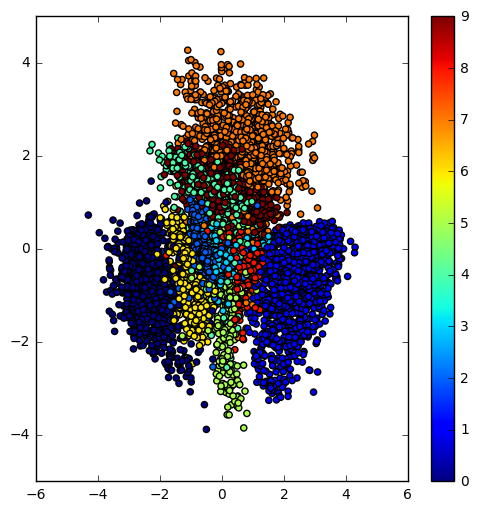

In [15]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [17]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

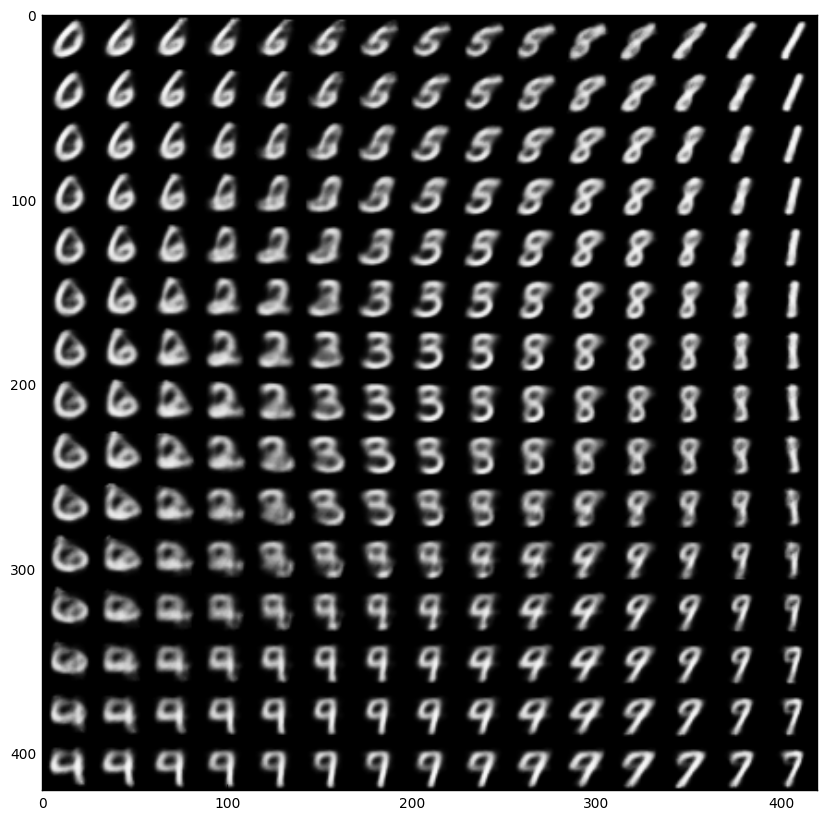

In [18]:
n = 15  
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()